<center>

# Deep Learning Solution for Data Classification

</center>

<br> &nbsp; &nbsp; The objective of this Notebook is to research and develop an implementation plan for an audio classification system to detect different sounds related to crime and antisocial behavior. I will be implementing my solution using the dataset "UrbanSound8K" starting by data preparation, i will follow these steps : 
1. Prepare Training Data
2. Pre-process Training Data
3. Build the model
4. Train the Model
5. Inference

### The Dataset :

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes:

The meta-data contains 8 columns:

- **slice_file_name**: name of the audio file

- **fsID**: FreesoundID of the recording where the excerpt is taken from

- **start**: start time of the slice

- **end**: end time of the slice

- **salience**: salience rating of the sound. 1 = foreground, 2 = background

- **fold**: The fold number (0-9) to which this file has been allocated

- **classID**:

    - 0 = air_conditioner
    - 1 = car_horn
    - 2 = children_playing
    - 3 = dog_bark
    - 4 = drilling
    - 5 = engine_idling
    - 6 = gun_shot
    - 7 = jackhammer
    - 8 = siren
    - 9 = street_music

- **class**: class name

In [1]:
#Starting by importing the necessary libraries 

import numpy as np 
import pandas as pd 
import seaborn as sns

import librosa as lb
import librosa.display
import glob 
import os

import matplotlib.pyplot as plt
%matplotlib inline 

import IPython.display as ipd

## Preparing Data :

In [2]:
# Loading the metadata file

df = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')

In [3]:
# Displaying the first few rows of the dataframe

df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [4]:
# Generating descriptive statistics for numerical columns

df.describe()

fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000

In [5]:
# Output the dimensions of the dataframe (rows, columns)

df.shape

(8732, 8)

In [6]:
# Displaying the data types of each column

df.dtypes

slice_file_name     object
fsID                 int64
start              float64
end                float64
salience             int64
fold                 int64
classID              int64
class               object
dtype: object

In [7]:
# Group by 'classID' and list unique 'class' names for each classID

classes = df.groupby('classID')['class'].unique()
classes

classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object

#### I started by looking for Missing values and duplicates :

In [8]:
df.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [9]:
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [slice_file_name, fsID, start, end, salience, fold, classID, class]
Index: []


#### From here I have seen that i can continue the work and I went to see the Balance of the Data :

In [10]:
df['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

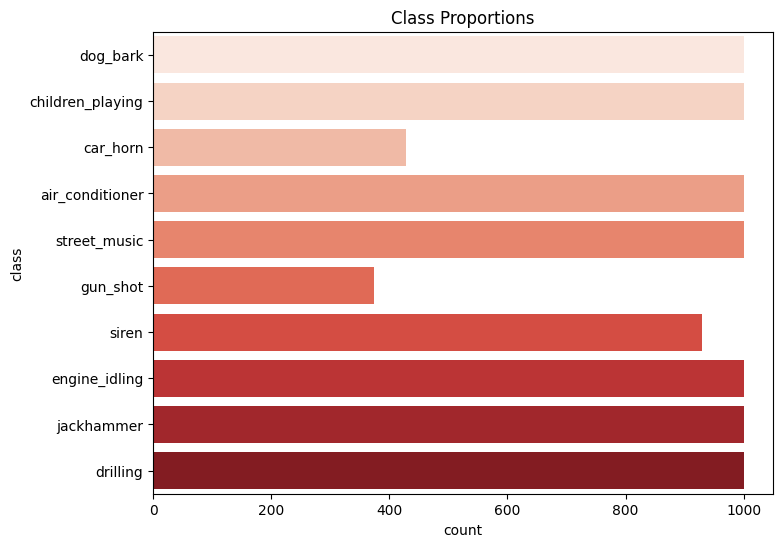

In [11]:
# plot horizontal bar chart
plt.figure(figsize=(8, 6))
sns.countplot(y='class', data=df, palette='Reds')
plt.title('Class Proportions')
plt.show()

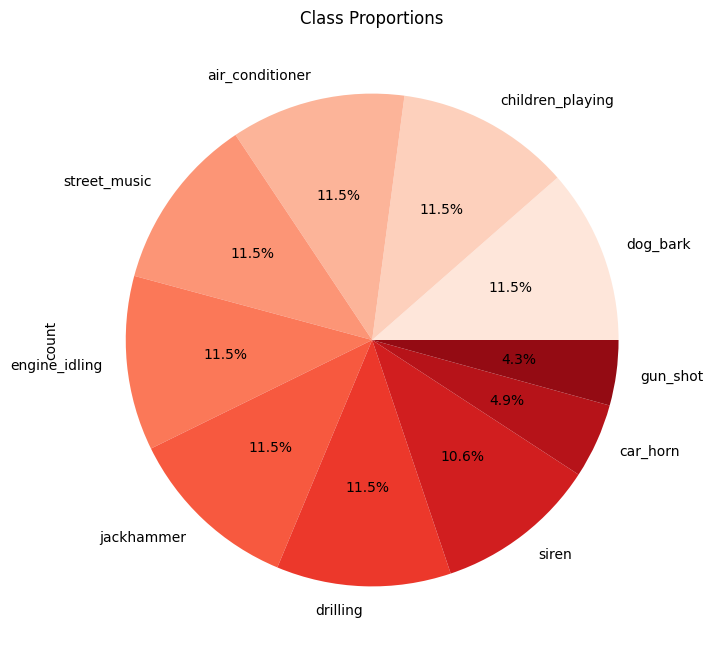

In [12]:
# Plot pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('Reds', n_colors=len(df['class'].unique()))
df['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title('Class Proportions')
plt.show()

#### Based on the plots, it is evident that 'Car_horn' and 'gun_shot' are underrepresented in the dataset compared to other classes. To address this class imbalance issue, I initially considered data augmentation techniques but i preferred to do  oversampling using SMOTE technique after splitting the data. This approach will help to balance the number of samples in each class and improve the performance of the classification model.

In [ ]:
#The first audio file of the dataset

filename = "/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav"
audiodata,sr=librosa.load(filename)

# Plot the audio waveform using librosa.display
librosa.display.waveshow(audiodata,sr=sr)

# Play the audio file using IPython.display.Audio
ipd.Audio(filename)

## Pre-processing:

In [ ]:
# Time Series on classes:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = lb.load(fp)
        raw_sounds.append(X)
    return raw_sounds

In [ ]:
def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(35,10))
    
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        librosa.display.waveshow(np.array(f),sr=22050, color='orange', alpha=0.7,where = 'post')
        plt.title(n.title(), fontsize = 20)
        i += 1
        
    fig.suptitle('Figure 1: Waveplot, Time Series', fontsize=18)
    plt.savefig("time_series")
    plt.tight_layout()
    plt.show()

def plot_spec(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(35,10))
    
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(2,5,i)
        d =librosa.amplitude_to_db(np.abs(librosa.stft(f)), ref=np.max)
        librosa.display.specshow(d, y_axis='linear')
        plt.colorbar(format='%+2.0f dB')
        plt.title(n.title(), fontsize = 20)
        i += 1
        
    fig.suptitle('Figure 2: Linear-Frequency Power Spectrogram', fontsize=18)
    plt.savefig("spectrogram")
    plt.tight_layout()
    plt.show()

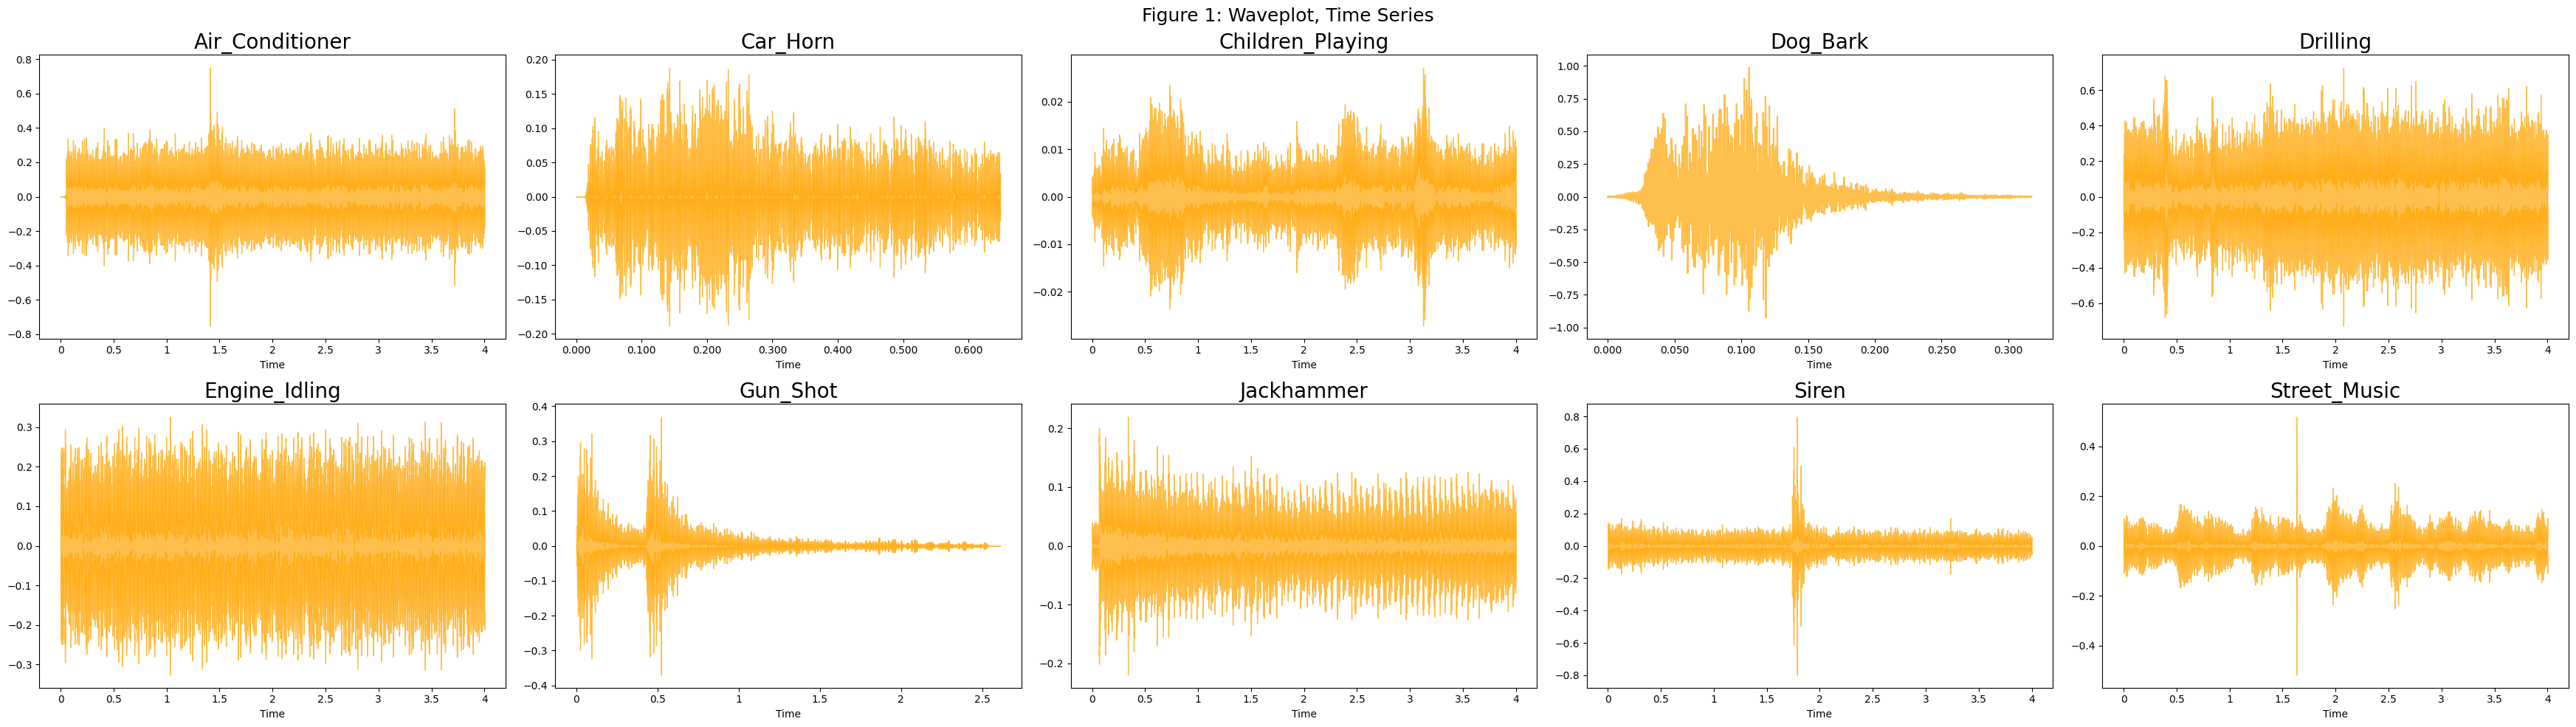

In [16]:
sound_file_paths = ["/kaggle/input/urbansound8k/fold5/100852-0-0-0.wav","/kaggle/input/urbansound8k/fold10/100648-1-0-0.wav",
                   "/kaggle/input/urbansound8k/fold5/100263-2-0-117.wav","/kaggle/input/urbansound8k/fold5/100032-3-0-0.wav",
                   "/kaggle/input/urbansound8k/fold3/103199-4-0-3.wav","/kaggle/input/urbansound8k/fold10/102857-5-0-0.wav",
                   "/kaggle/input/urbansound8k/fold1/102305-6-0-0.wav","/kaggle/input/urbansound8k/fold1/103074-7-1-0.wav",
                   "/kaggle/input/urbansound8k/fold7/102853-8-0-2.wav","/kaggle/input/urbansound8k/fold7/101848-9-0-9.wav"]
classes = list(np.unique(df['class']))

raw_sounds = load_sound_files(sound_file_paths)
plot_waves(classes,raw_sounds)

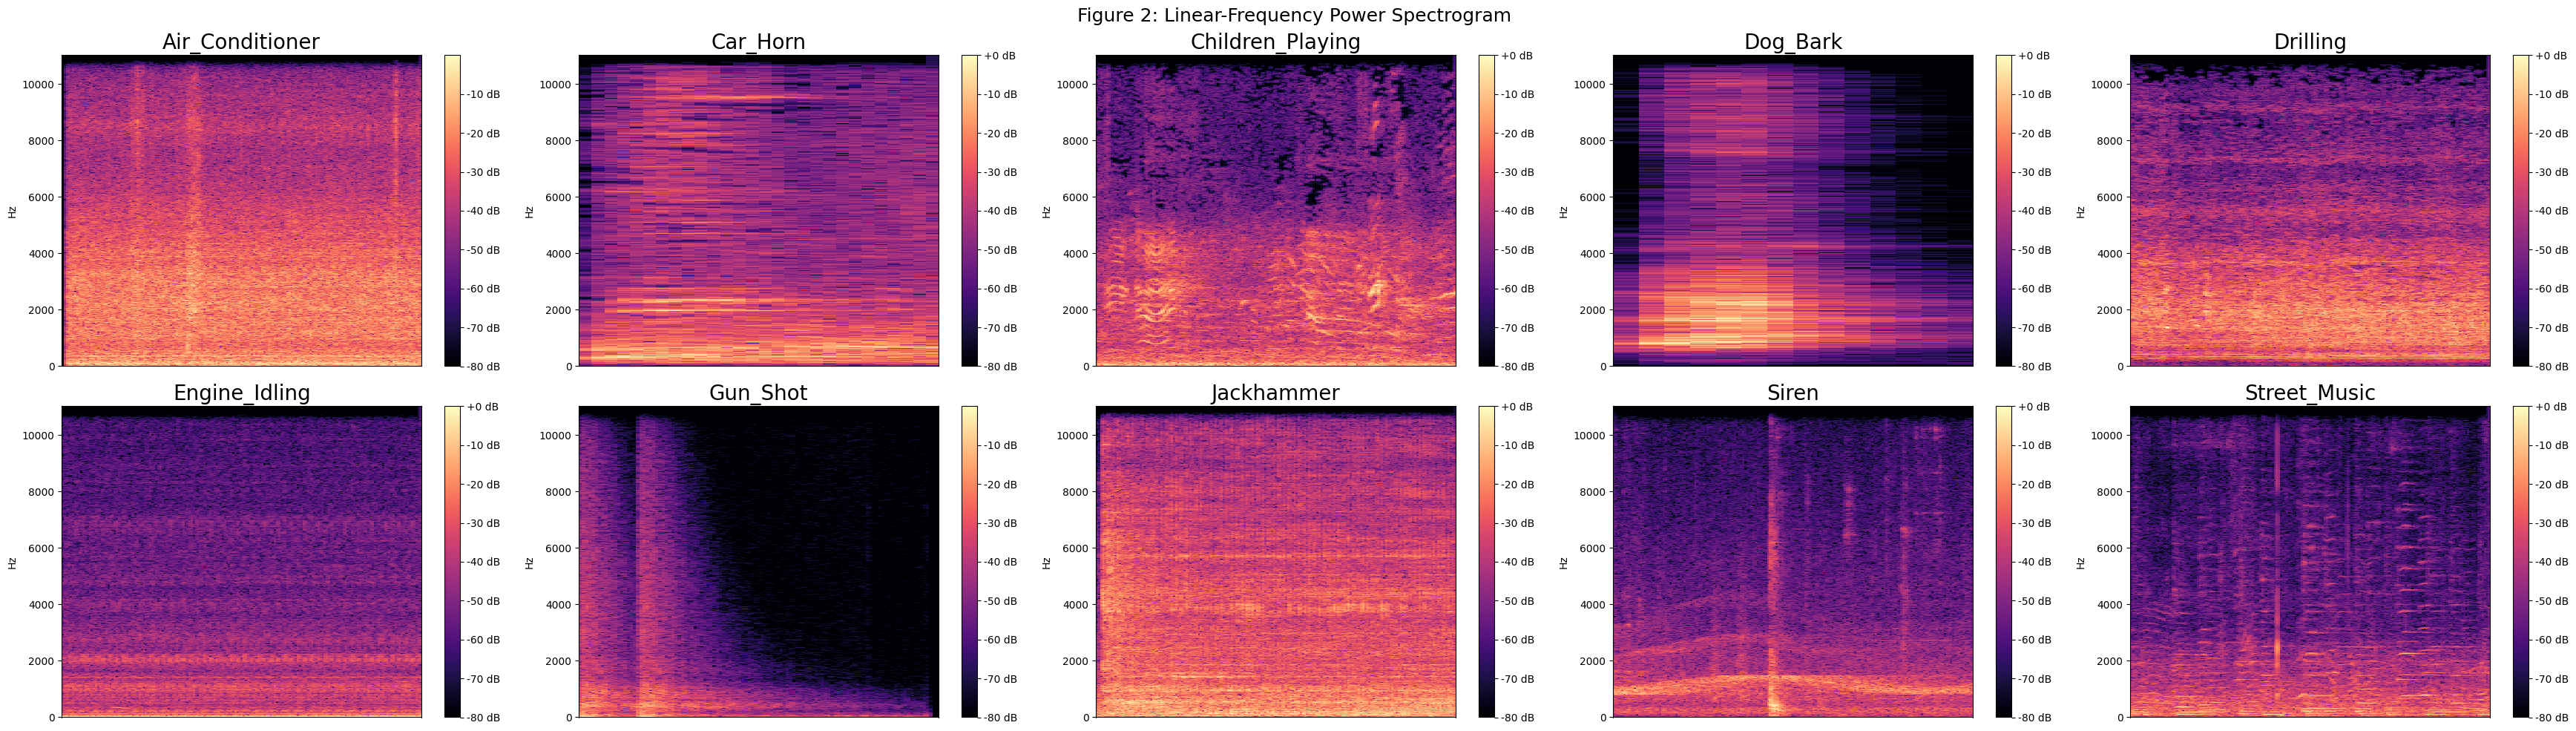

In [17]:
plot_spec(classes,raw_sounds)

#### Those wave plot showed me that the audio files of the class 'children playing' have the lowest amplitude so i tried to balance one example but i have seen that it did not have an impact in sound so i did not proceed to balance the whole class. 

Original audio:


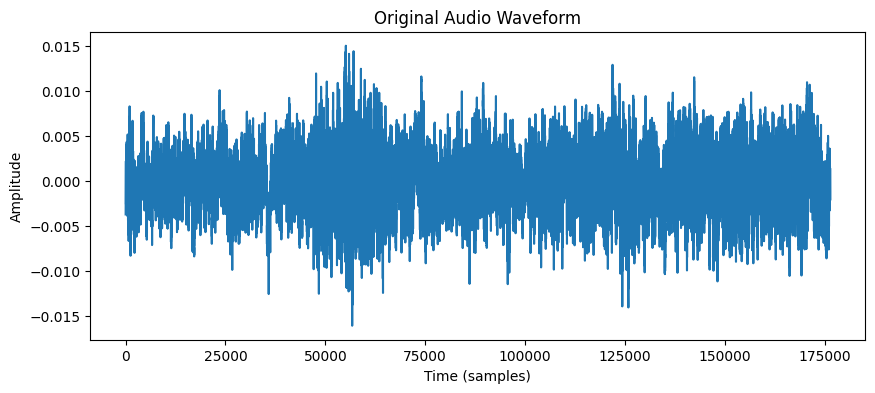

Normalized audio:


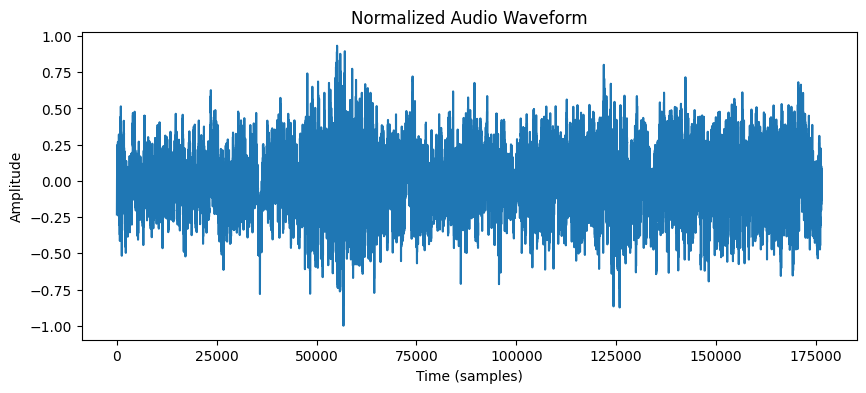

Original audio max value: 0.015029907
Normalized audio max value: 0.9327651
Original audio min value: -0.016113281
Normalized audio min value: -1.0


In [18]:
audio, sr = librosa.load('/kaggle/input/urbansound8k/fold5/100263-2-0-121.wav', sr=None, mono=True)

# Print the original audio waveform
print("Original audio:")
ipd.display(ipd.Audio(audio, rate=sr))
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title('Original Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# Normalize the audio
normalized_audio = audio / max(abs(audio))

# Print the normalized audio waveform
print("Normalized audio:")
ipd.display(ipd.Audio(normalized_audio, rate=sr))
plt.figure(figsize=(10, 4))
plt.plot(normalized_audio)
plt.title('Normalized Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# Print the maximum and minimum values of the audio array
print("Original audio max value:", max(audio))
print("Normalized audio max value:", max(normalized_audio))
print("Original audio min value:", min(audio))
print("Normalized audio min value:", min(normalized_audio))

#### I decided to use MFCC (Mel Frequency Cepstral Coefficients)  for feature extraction as is widely used feature extraction technique for audio data. It represents the spectrum of a sound signal using a set of features that capture important aspects of the sound such as frequency and amplitude i think that it is a good choice because it is designed to be robust to changes in spectral content, which is often present in urban sound environments where there can be a lot of background noise and variations in frequency.

In [19]:
def feature_extract(path):
    data, sr = lb.load(path) # load audio file and sampling rate
    mfccs = lb.feature.mfcc(y=data, sr=sr, n_mfcc=128) # extract MFCC features
    mfccs = np.mean(mfccs, axis=1) # compute mean of MFCCs along each feature dimension
    return mfccs

# Load the dataset
data = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")

# Extract features and labels
x = []
y = []
for i in range(len(data)):
    path = "/kaggle/input/urbansound8k/fold" + str(data.loc[i , 'fold']) +"/" + str(data.loc[i , "slice_file_name"])
    feature_vector = feature_extract(path)
    if feature_vector is not None:
        x.append(feature_vector)
        y.append(data.loc[i , 'classID'])
    if(i%50 == 0):
        print(i)
        
X = np.array(x)
y = np.array(y)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


8350
8400
8450
8500
8550
8600
8650
8700


#### Splitting the data to 85% Train set, 10% Validation set and 5% test set 

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.15, random_state=40)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=40)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7422, 128)
(433, 128)
(877, 128)


#### Checking the balance of the train set before using SMOTE to balance it.

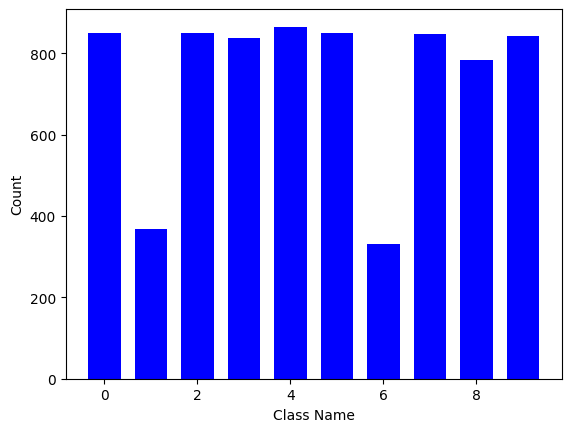

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Get the counts of each class in the training data
class_counts = Counter(y_train)

# Plot a bar chart with the counts of each class
plt.bar(class_counts.keys(), class_counts.values(), width=0.7, color='blue')

# Add labels to the x-axis and y-axis
plt.xlabel('Class Name')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
smote = SMOTE()

# Oversampling the train data
X_train,y_train = smote.fit_resample(X_train,y_train)

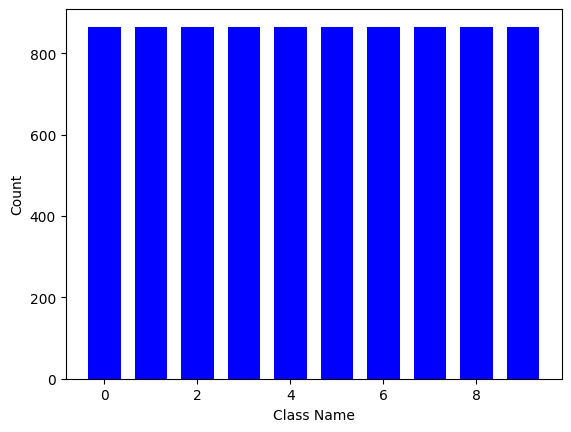

In [ ]:

# Get the counts of each class in the training data
class_counts = Counter(y_train)

# Plot a bar chart with the counts of each class
plt.bar(class_counts.keys(), class_counts.values(), width=0.7, color='blue')

# Add labels to the x-axis and y-axis
plt.xlabel('Class Name')
plt.ylabel('Count')

# Show the plot
plt.show()


#### Now the Train set is balanced and i can build my model.

## Training:

In [ ]:
from tensorflow.keras.utils import to_categorical 

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

2024-06-20 01:44:07.206312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 01:44:07.206463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 01:44:07.392878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### I chose 1D Convolutional Neural Networks (1DCNN) as a model because they are able to efficiently process sequential data, learn local features, and are translation invariant, all of which are important for audio classification tasks.

#### I also implemented Early stopping as it helps to prevent overfitting and can save time and resources.

#### The kernel_size is set to 2 as smaller kernel sizes are effective in capturing fine-grained features in the data,and started with 16 filters to establish a baseline model with a moderate level of complexity. This initial setup helps to identify if the model is capable of learning from the data without introducing too much computational cost. For the Dense layer I chose 128 units, providing sufficient capacity to learn complex representations after the convolutional layers.

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(128, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#Define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 127, 16)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 62, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,562 (506.10 KB)

 Trainable params: 129,562 (506.10 KB)

 Non-trainable params: 0 (0.00 B)

#### I launched the training with 100 epochs as this ensures that the model has ample opportunity to learn from the data. Given the complexity of neural networks, especially in tasks like audio classification.

In [ ]:
# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[earlystop])

# Evaluate the model on the test set
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
model.evaluate(X_test, y_test)

Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1683 - loss: 3.0338 - val_accuracy: 0.4447 - val_loss: 1.7856
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3446 - loss: 1.8044 - val_accuracy: 0.5564 - val_loss: 1.4698
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4371 - loss: 1.5588 - val_accuracy: 0.6351 - val_loss: 1.2178
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5129 - loss: 1.3788 - val_accuracy: 0.6762 - val_loss: 1.0961
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5654 - loss: 1.2582 - val_accuracy: 0.7446 - val_loss: 0.9324
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5935 - loss: 1.1770 - val_accuracy: 0.7583 - val_loss: 0.8408
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6102 - loss: 1.1198 - val_accuracy: 0.7628 - val_loss: 0.8208
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6583 - loss: 1.0106 - 

[0.3520779013633728, 0.8683602809906006]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.2509


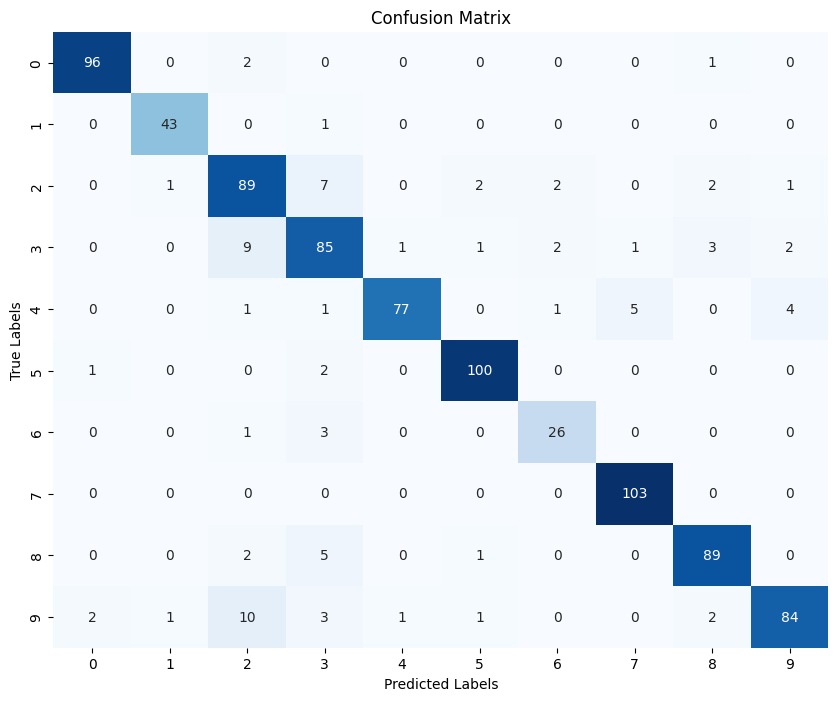

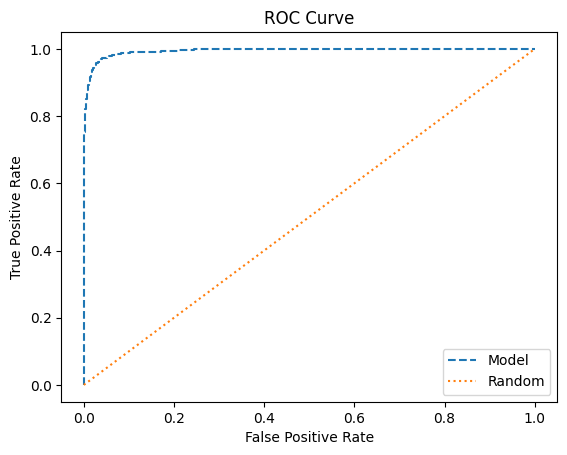

Sensitivity: [0.96969697 0.97727273 0.85576923 0.81730769 0.86516854 0.97087379
 0.86666667 1.         0.91752577 0.80769231]


Specificity: 1.0


Loss: 0.3058615028858185
AUC: 0.9933073539930994


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

# Predict the classes of the test set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

# Calculate the sensitivity and specificity
tn, fp = cm.ravel()[:2]
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate the loss and AUC
loss, accuracy = model.evaluate(X_val, y_val)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')


plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


fpr, tpr, thresholds = roc_curve(y_val.ravel(), y_pred.ravel())
plt.plot(fpr, tpr, linestyle='--', label='Model')
plt.plot([0, 1], [0, 1], linestyle=':', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
# Print the results
print("Sensitivity:", sensitivity)
print('\n')
print("Specificity:", specificity)
print('\n')
print("Loss:", loss)
print("AUC:", auc)


Text(0.5, 1.0, 'Accuracy Curves')

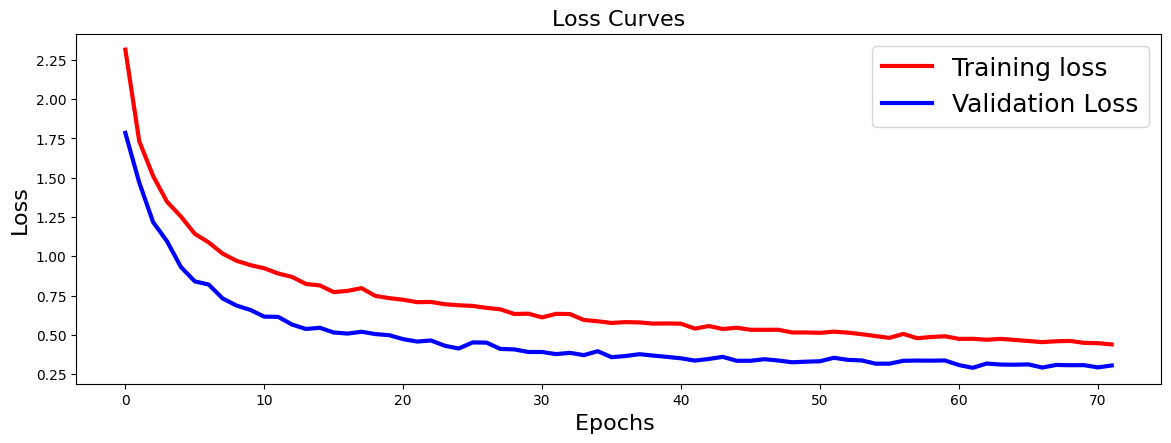

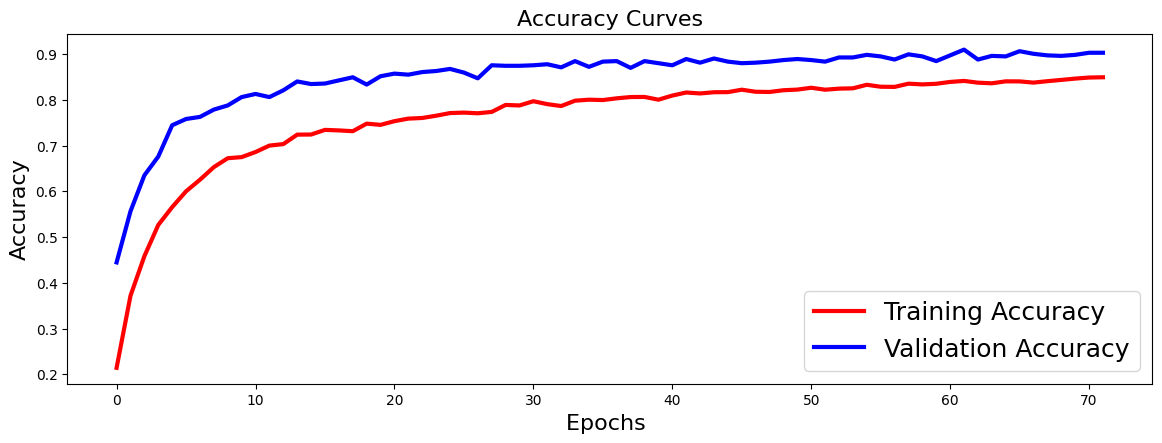

In [30]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### This got me good value, but i tried to increase the number of filters in the convolutional layers, higher filter numbers allow the model to learn more complex and diverse features. I also increased the number of units in the dense layer, enhancing the model's capacity to learn from the extracted features.
#### For the epochs and batch size, I kept it constant to isolate the effect of changing the filters and dense units. This approach ensures that the observed improvements are due to the increased model capacity rather than changes in training duration or batch processing.

In [31]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(128, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#Define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 127, 32)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 62, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 30, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,114 (1.97 MB)

 Trainable params: 515,114 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[earlystop])

# Evaluate the model on the test set
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
model.evaluate(X_test, y_test)

Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2513 - loss: 2.4995 - val_accuracy: 0.5872 - val_loss: 1.3343
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5250 - loss: 1.3572 - val_accuracy: 0.7081 - val_loss: 0.9769
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6162 - loss: 1.1160 - val_accuracy: 0.7765 - val_loss: 0.7856
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6701 - loss: 0.9977 - val_accuracy: 0.7811 - val_loss: 0.6815
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7167 - loss: 0.8344 - val_accuracy: 0.8233 - val_loss: 0.5820
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7414 - loss: 0.7709 - val_accuracy: 0.8415 - val_loss: 0.5098
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7546 - loss: 0.7132 - val_accuracy: 0.8700 - val_loss: 0.4861
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7852 - loss: 0.6265 - 

[0.23186784982681274, 0.912240207195282]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9252 - loss: 0.2354


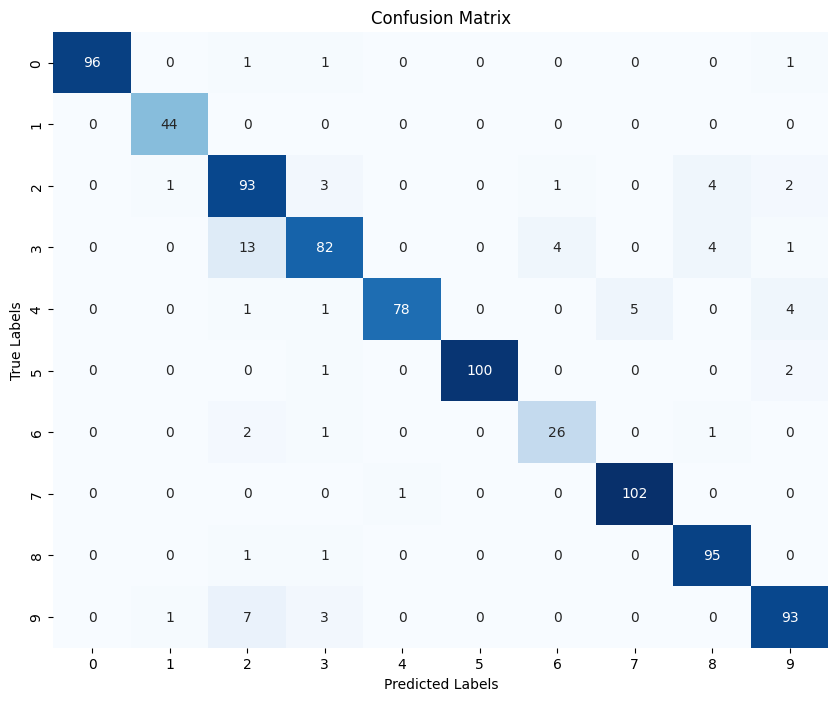

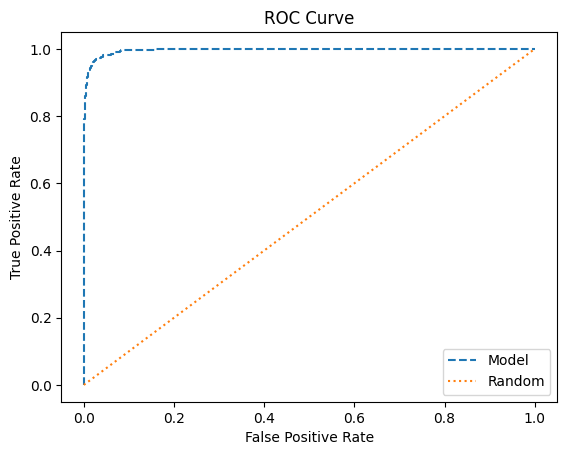

Sensitivity: [0.96969697 1.         0.89423077 0.78846154 0.87640449 0.97087379
 0.86666667 0.99029126 0.97938144 0.89423077]


Specificity: 1.0


Loss: 0.2619988024234772
AUC: 0.9953810344857741


In [34]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)


tn, fp = cm.ravel()[:2]
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


loss, accuracy = model.evaluate(X_val, y_val)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')


plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


fpr, tpr, thresholds = roc_curve(y_val.ravel(), y_pred.ravel())
plt.plot(fpr, tpr, linestyle='--', label='Model')
plt.plot([0, 1], [0, 1], linestyle=':', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
# Print the results
print("Sensitivity:", sensitivity)
print('\n')
print("Specificity:", specificity)
print('\n')
print("Loss:", loss)
print("AUC:", auc)


Text(0.5, 1.0, 'Accuracy Curves')

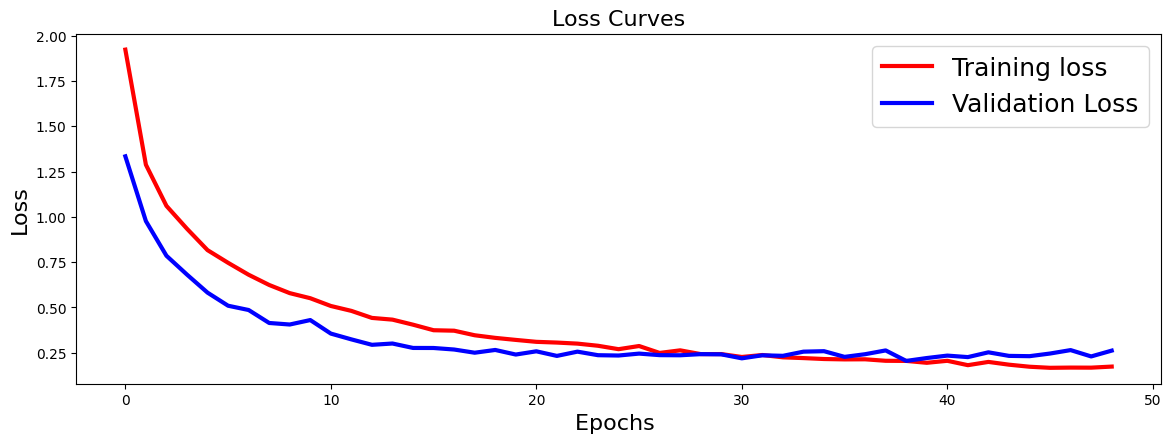

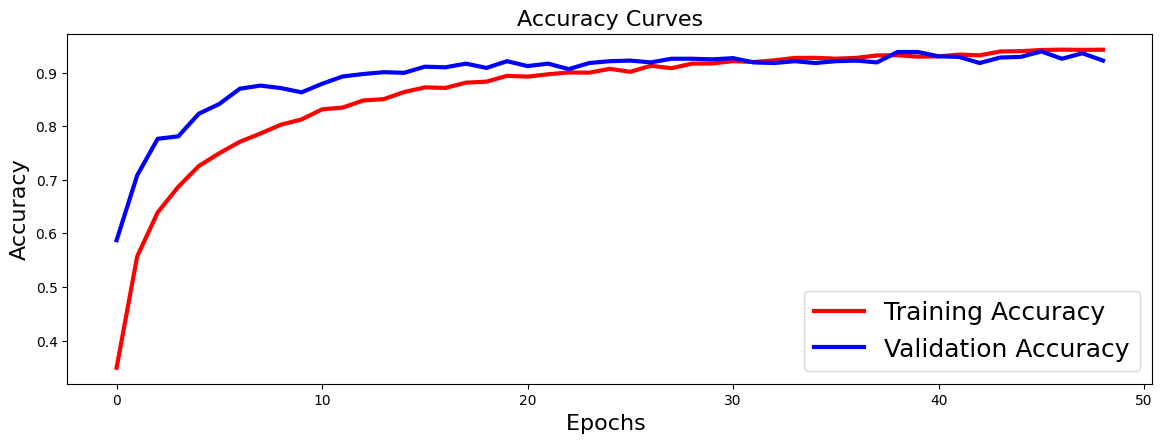

In [35]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### The increased number of filters and dense units led to improved evaluation metrics and inference results, suggesting that the model benefited from the additional capacity to learn more detailed and varied patterns in the audio data.

## Inferencing:

In [36]:
from IPython.display import Audio

def prediction_(audio_path):
    data, sr = lb.load(audio_path)
    mfccs = lb.feature.mfcc(y=data, sr=sr, n_mfcc=128)
    mfccs_mean = np.mean(mfccs, axis=1)  # Compute mean of MFCCs along each feature dimension
    mfccs_mean = mfccs_mean.reshape(1, -1)  # Reshape data to match the model input shape

    # Make predictions using your existing model instance
    predictions = model.predict(mfccs_mean)

    # Convert predictions to class labels
    predicted_class = np.argmax(predictions)

    # Print the predicted class
    print("Predicted class:", predicted_class)
    
    # Assuming classes is defined elsewhere
    class_name = classes[predicted_class]
    pred_prob = predictions[0][predicted_class]  # Get probability for the predicted class
    print(f"This belongs to class {predicted_class}: {class_name} with {pred_prob * 100:.2f}% probability")
    
    # Play the audio
    display(Audio(data, rate=sr))


In [37]:
prediction_("/kaggle/input/audios/Jackhammer.WAV")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: 7
This belongs to class 7: jackhammer with 93.91% probability


In [38]:
prediction_("/kaggle/input/audios/mixkit-children-crowd-chanting-449.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 2
This belongs to class 2: children_playing with 97.18% probability


#### I downloaded a variety of audio samples from the internet to test the model's performance on real-world data that it had not encountered during training. The model performed well on these external samples, demonstrating its ability to generalize effectively to new, unseen audio data. This indicates that the model has learned robust features that are applicable beyond the training dataset.